In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
# Convertire immagini MNIST in tensori di 4 dimensioni (n di immagini, altezza, larghezza e canali)
transform = transforms.ToTensor()
# Dati di training
train_data = datasets.MNIST(root = 'cnn_data', train = True, download=True, transform=transform)
# Dati di test
test_data = datasets.MNIST(root = 'cnn_data', train = False, download=True, transform=transform)
# Dataloader
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
# Definiamo la CNN
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
# Prendiamo 1 immagine MNIST
for i, (x_train, y_train) in enumerate(train_data):
    break
x_train.shape

In [ ]:
# Convertire l'immagine in 4D
x = x_train.view(1, 1,28,28)
# Prima convoluzione
x = F.relu(conv1(x)) # Funzione di Attivazione
# x.shape OUTPUT: 1,6,26,26: 1 è l'immagine singola, 
# 6 i filtri che abbiamo chiesto (riga 24),
# 26*26 è l'immagine.
# Pooling layer
x = F.max_pool2d(x, 2, 2) # Kernel size 2 e stride 2 
x = F.relu(conv2(x))
x = F.max_pool2d(x, 2, 2)

In [ ]:
# Classe del modello
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Fully connected layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # 2 x 2 Kernel e Stride 2
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 16*5*5) # Numero negativo cosi possiamo variare la dimensione del batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
# Creiamo un istanza del modello
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [ ]:
#Loss FN Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Allenamento
# Variabili
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Loop
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    # train
    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1 # Inizializziamo i nostri batches a 1
        y_pred = model(x_train) # Prendiamo la y iniziale dal nostro set di addestramento
        loss = criterion(y_pred, y_train) # Confrontiamo la predizione con le risposte corrette in y_train
        
        predicted = torch.max(y_pred.data, 1)[1] # Aggiungere il numero delle predizioni corrette. Indicizzato al primo punto
        batch_corr = (predicted == y_train).sum() # Quando è stato corretto dal suo batch. True = 1, False = 0
        trn_corr += batch_corr # Tiene traccia mentre procediamo con l'allenamento
        # Aggiornamento Parametri
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
    train_losses.append(loss)
    train_correct.append(trn_corr)

In [ ]:

# Test
with torch.no_grad(): # No gradienti perché non vogliamo aggiornare i pesi nel test
    for b,(x_test, y_test) in enumerate(test_loader):
        y_val = model(x_test)
        predicted = torch.max(y_val.data, 1)[1] # Aggiunge predizioni corrette
        tst_corr += (predicted == y_test).sum()
loss = criterion(y_val, y_test)
test_losses.append(loss)
test_correct.append(tst_corr)


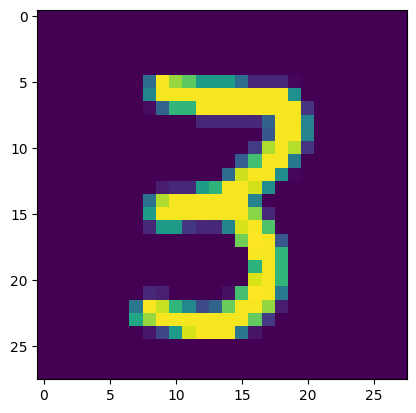

In [168]:
img_idx = 5214
# Prendiamo un'immagine
test_data[img_idx] # tensore con un immagine e mostrerà il label 
# Prendiamone solo i dati
test_data[img_idx][0]
# Ridimensioniamo
test_data[img_idx][0].reshape(28, 28)
# Mostrare
plt.imshow(test_data[img_idx][0].reshape(28, 28)
)

In [169]:
# Passiamo l'immagine al model
model.eval()
with torch.no_grad():
    new_pred = model(test_data[img_idx][0].view(1,1,28,28)) #batch_size di 1, 1 canale dei colori, dimensione 28*28
# probabilità 
new_pred 

tensor([[-21.9002,  -7.2020,  -7.7074,  11.6253, -16.8083,  -3.5839, -21.1401,
          -7.0264, -10.0031,  -8.9535]])

In [167]:
new_pred.argmax()

tensor(1)